## Import necessary libraries

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

## Extract CSV File

In [3]:
data = pd.read_csv('resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


#### To obtain `CombinedDataCleaned` (no outliers from both NumData and CatData)


In [4]:
NumData = pd.DataFrame(data[['floor_area_sqm', 'lease_commence_date']])


In [5]:
flat_type = pd.DataFrame(data[['flat_type']])
mapping = {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4, '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}
data['flat_type_num'] = flat_type['flat_type'].map(mapping)

storey_range = pd.DataFrame(data[['storey_range']])
mapping = {'01 TO 03': 2, '04 TO 06': 5, '07 TO 09': 8, '10 TO 12': 11, '13 TO 15': 14, '16 TO 18': 17, '19 TO 21': 20, '22 TO 24': 23, '25 TO 27': 26, '28 TO 30': 29, '31 TO 33': 32, '34 TO 36': 35, '37 TO 39': 38, '40 TO 42': 41}
data['Story_range_num'] = storey_range["storey_range"].map(mapping)

flat_model = pd.DataFrame(data[['flat_model']])
mapping = {'2-room': 1, 'Adjoined flat': 2, 'Apartment': 3, 'Improved': 4, 'Improved-Maisonette': 5, 'Maisonette': 6, 'Model A': 7, 'Model A-Maisonette': 8, 'Model A2': 9, 'Multi Generation': 10, 'New Generation': 11, 'Premium Apartment': 12, 'Premium Maisonette': 13, 'Simplified': 14, 'Standard': 15, 'Terrace': 16}
data['flat_model_num'] = flat_model['flat_model'].map(mapping)

CatData = pd.DataFrame(data[['flat_type_num', 'Story_range_num','flat_model_num']])

CombinedDataCleaned = pd.concat([NumData, CatData,data['resale_price']], axis=1)

CombinedDataCleaned.info()

# Calculate the quartiles
Q1 = CombinedDataCleaned.quantile(0.25)
Q3 = CombinedDataCleaned.quantile(0.75)

# Rule to identify outliers
rule = ((CombinedDataCleaned < (Q1 - 1.5 * (Q3 - Q1))) | (CombinedDataCleaned > (Q3 + 1.5 * (Q3 - Q1))))

outliers = rule.any(axis = 1)   # axis 0 is row, 1 is column

# Which row indices correspond to outliers in the dataframe?
outlierindices = outliers.index[outliers == True]



# Remove the outliers based on the row indices obtained above
CombinedDataCleaned.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
CombinedDataCleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369651 entries, 0 to 369650
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       369651 non-null  float64
 1   lease_commence_date  369651 non-null  int64  
 2   flat_type_num        369651 non-null  int64  
 3   Story_range_num      369651 non-null  int64  
 4   flat_model_num       369651 non-null  int64  
 5   resale_price         369651 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 16.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 360419 entries, 0 to 369648
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   floor_area_sqm       360419 non-null  float64
 1   lease_commence_date  360419 non-null  int64  
 2   flat_type_num        360419 non-null  int64  
 3   Story_range_num      360419 non-null  int64  
 4   flat_model_num 

## Neural Network

**Reasons for Neural Network** <br>

We used Neural Network because it is often used for predicting complex and non-linear relationships between variables. In the case of predicting the output resale_price of HDB, there may be many variables that could potentially influence the price.<br>

A neural network model can take all of these variables into account and identify the most important features for predicting the price. <br>

Neural networks can be scaled up or down depending on the size and complexity of the data, making them suitable for both small and large-scale applications.<br>

**Detailed & formal introduction to your model** <br>

**Input** <br>
Dataset with one or more predictor variables (X) that produces corresponding outcome variable (y) --> `resale_price` <br>

**Output** <br>
Predicted resale price of the flat based on the inputs <br>

**How we trained and choice of hyperparameters of  model**
1. We split the dataset into training and test sets.<br>
2. We perform scaling of the features to speed up convergence: If the input features have different scales, the gradient descent algorithm will take longer to converge and reduce the number of iterations required for convergence. To prevent dominant features: If some features have much larger values than others, the neural network might give too much importance to those features, which could result in overfitting. By scaling the features, we can ensure that each feature contributes equally to the model. <br>
3. We define two hidden layers. First hidden layer: number of units = 64, activation function = ReLU. Second hidden layer: number of units = 64, activation function = ReLU. The values are chosen because they are common choices for regression problems and has shown good performance in practice.
4. Since we have over 300000 rows of data, we will not be using GridSearch to evaluate the model for the best hyperparameters since it would be too time costly. We will be using `Adam Optimization` with a `learning_rate` of 0.001 as it is a common starting point to be used to update the model's parameters during training to minimize the loss function of `MSE`.
5. History of the training process is stored and is printed out on the Visualisation of training history. Validation loss refers to the error between the predicted values and the actual values and Loss refers to the error between the predicted values and the actual values in the training data are being shown in the visualisation to show whether there is an improvement over time.
6. Performance metrics of MSE and R^2 are computed for train and test data and Predicted vs True values are plotted to provide analysis of the model
7. Permutation importance is then performed to evaluate the importance of each feature in the neural network, it works by randomly permuting the values of each feature in the test set and observing how much the performance of the model decreases. The features that have the greatest impact on performance when their values are permuted are considered to be the most important features. `n_repeats` of 10 where each feature is computed by shuffling its values 10 times and re-fitting the model is used to ensure a more accurate feature importance score to be obtained.
8. At the end, conclude with the performance metrics and features importance.


In [27]:
# Concatenate the numerical and categorical variables
X = CombinedDataCleaned.iloc[:, 0:5] # get columns 0 to 4
y = CombinedDataCleaned['resale_price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Define the neural network architecture
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/100
4506/4506 [==============================] - 6s 1ms/step - loss: 33928093696.0000 - val_loss: 7880814592.0000
Epoch 2/100
4506/4506 [==============================] - 5s 1ms/step - loss: 5705150464.0000 - val_loss: 4961814016.0000
Epoch 3/100
4506/4506 [==============================] - 5s 1ms/step - loss: 4897171968.0000 - val_loss: 4862554624.0000
Epoch 4/100
4506/4506 [==============================] - 6s 1ms/step - loss: 4844985856.0000 - val_loss: 4839005184.0000
Epoch 5/100
4506/4506 [==============================] - 6s 1ms/step - loss: 4824898048.0000 - val_loss: 4817640960.0000
Epoch 6/100
4506/4506 [==============================] - 6s 1ms/step - loss: 4810568192.0000 - val_loss: 4802159616.0000
Epoch 7/100
4506/4506 [==============================] - 6s 1ms/step - loss: 4795237376.0000 - val_loss: 4785946112.0000
Epoch 8/100
4506/4506 [==============================] - 5s 1ms/step - loss: 4776932864.0000 - val_loss: 4765255680.0000
Epoch 9/100
4506/4506 [========

## Visualisation of training history

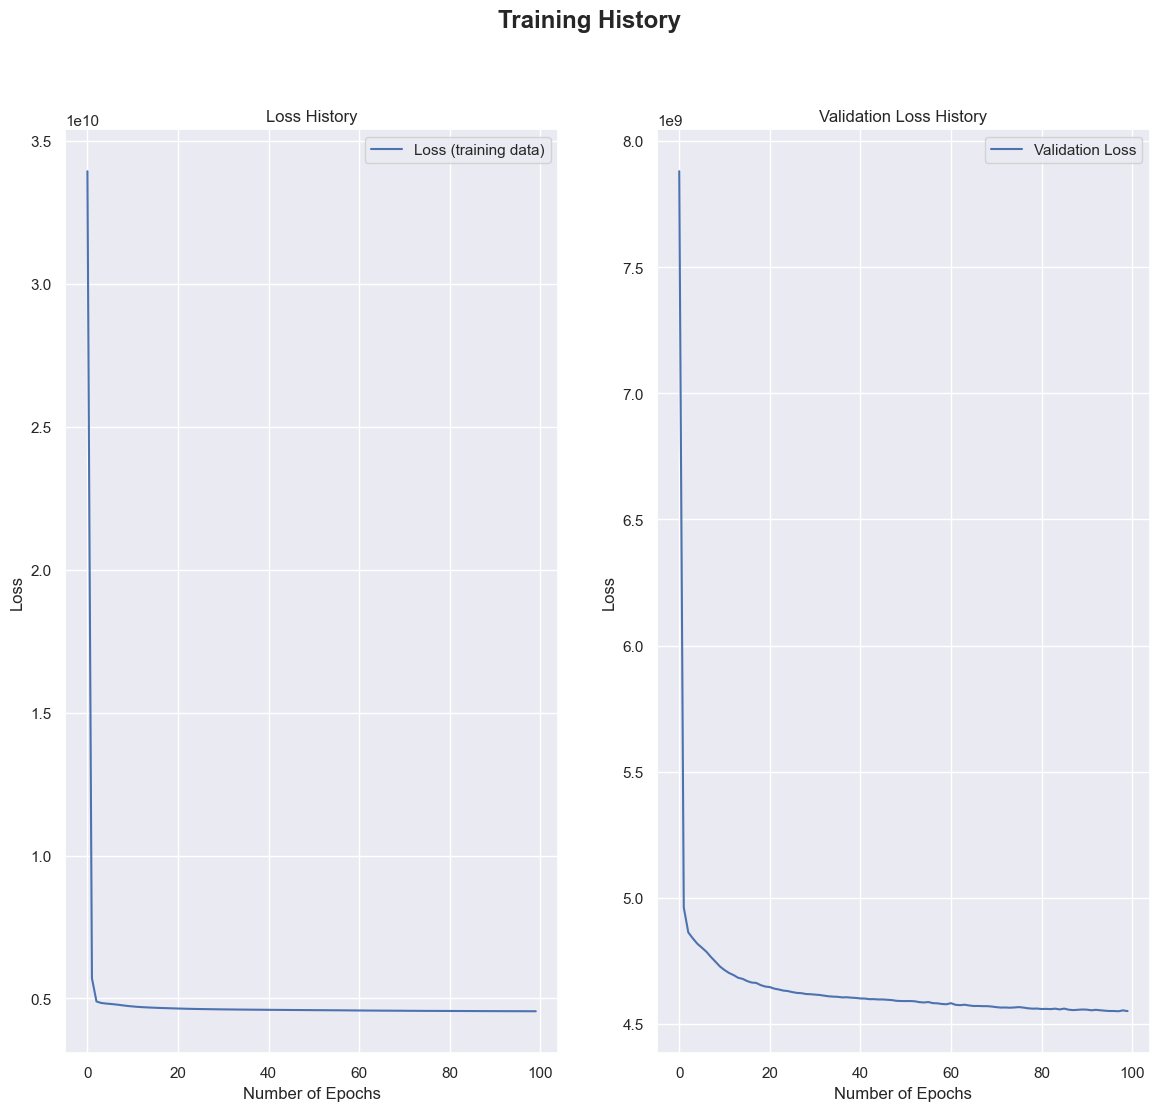

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 12))
f.suptitle('Training History', fontweight='bold', fontsize='x-large')

ax[0].plot(history.history['loss'], label='Loss (training data)')
ax[0].set_title('Loss History')
ax[0].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0].legend(loc="upper right")

ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Validation Loss History')
ax[1].set(ylabel='Loss', xlabel='Number of Epochs')
ax[1].legend(loc="upper right") 



Neural Network Model helps to improve prediction shown by the decrease in `loss` and `validation loss` functions. 

2253/2253 [==============================] - 2s 805us/step


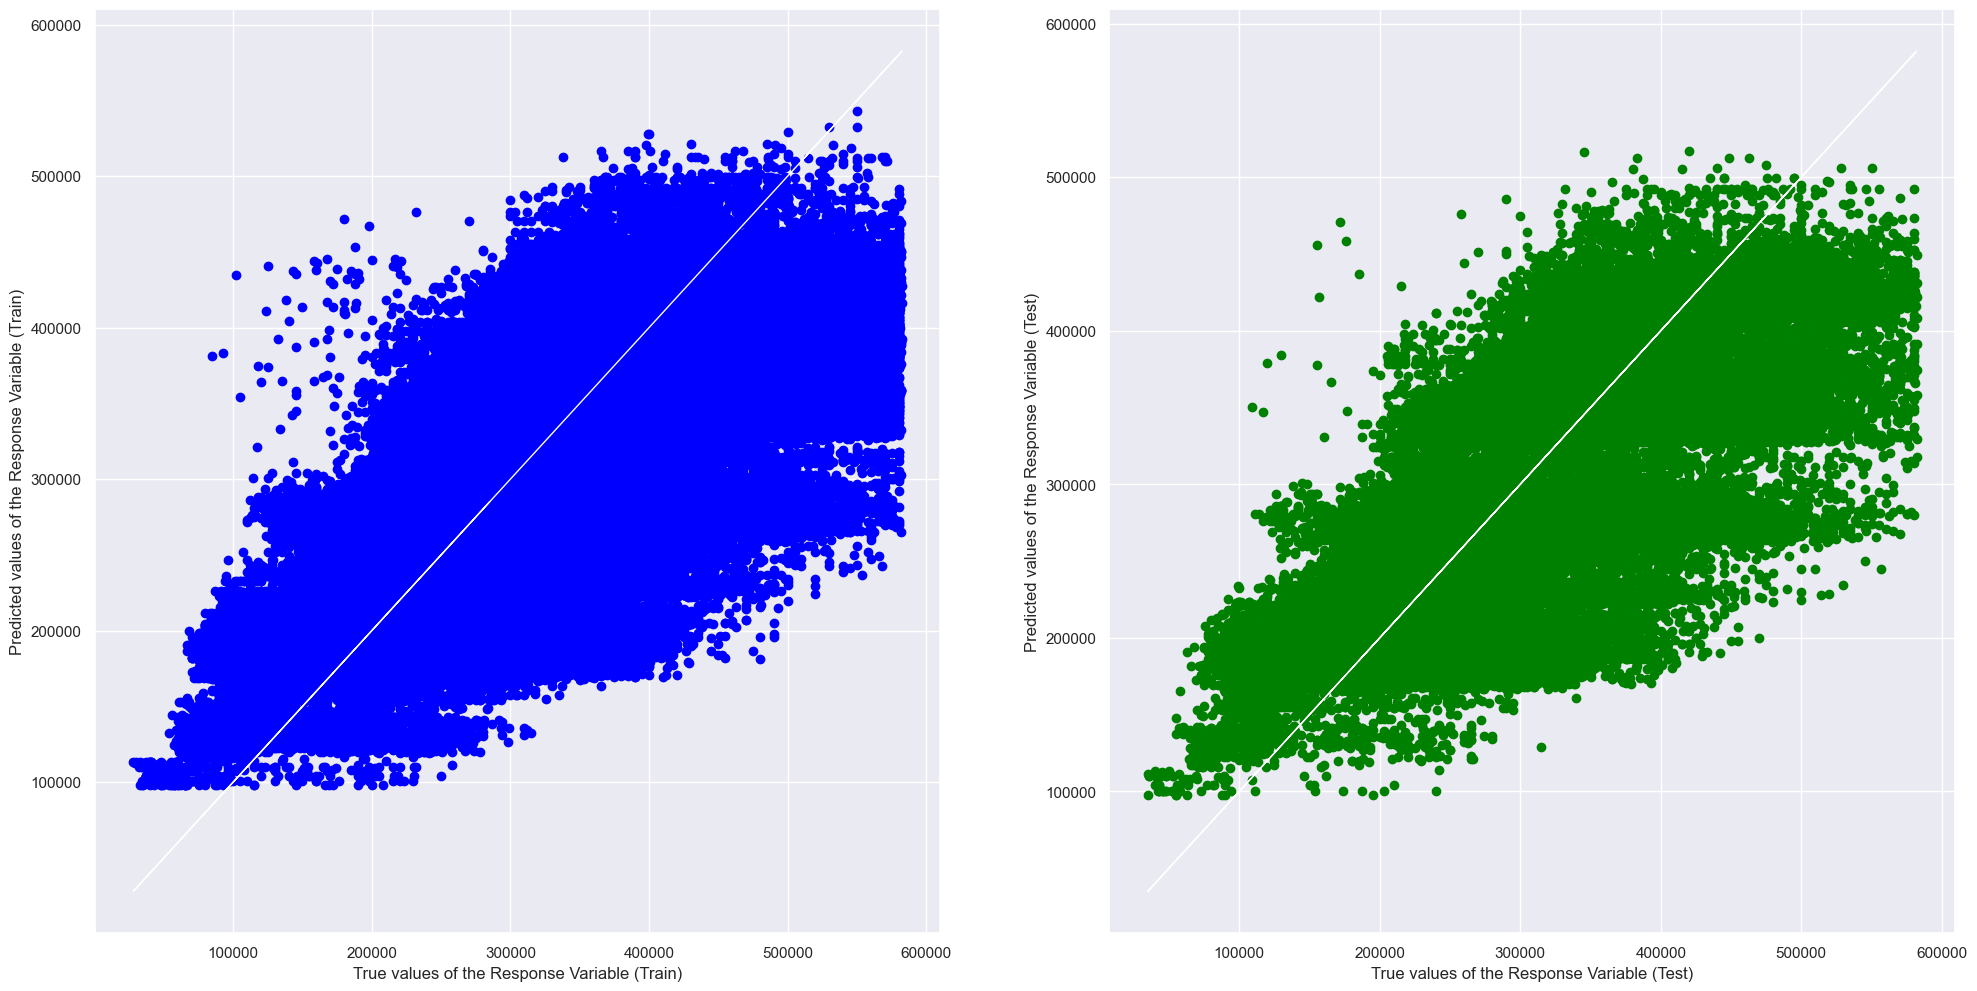

In [33]:
import matplotlib.pyplot as plt

# Predict on training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

## Checking of goodness of fit on train and test data

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict the target variable for the training set
y_train_pred = model.predict(X_train)

# Calculate the mean squared error and R-squared values for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Predict the target variable for the test set
y_test_pred = model.predict(X_test)

# Calculate the mean squared error and R-squared values for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_train)
print("Mean Squared Error (MSE) \t:", mse_train)
print()

# Check the Goodness of Fit (on Test Data)
print("Prediction Accuracy of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_test)
print("Mean Squared Error (MSE) \t:", mse_test)
print()

2253/2253 [==============================] - 2s 796us/step
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5657482205552902
Mean Squared Error (MSE) 	: 4552940227.775028

Prediction Accuracy of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5650209827838651
Mean Squared Error (MSE) 	: 4550537584.4318695



## Checking which features are the most important

In [7]:
from sklearn.inspection import permutation_importance

# Compute feature importance using permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, scoring='neg_mean_absolute_error')
importances = result.importances_mean
features = X.columns
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(1, X.shape[1]+1):
    if (f==1):
        print("")
    print("%d. feature '%s' (%f)" % (f, features[indices[f-1]], importances[indices[f-1]]))


2253/2253 [==============================] - 2s 761us/step
Feature ranking:

1. feature 'floor_area_sqm' (26063.089283)
2. feature 'flat_type_num' (9620.587276)
3. feature 'lease_commence_date' (5384.546597)
4. feature 'Story_range_num' (882.858086)
5. feature 'flat_model_num' (490.950037)


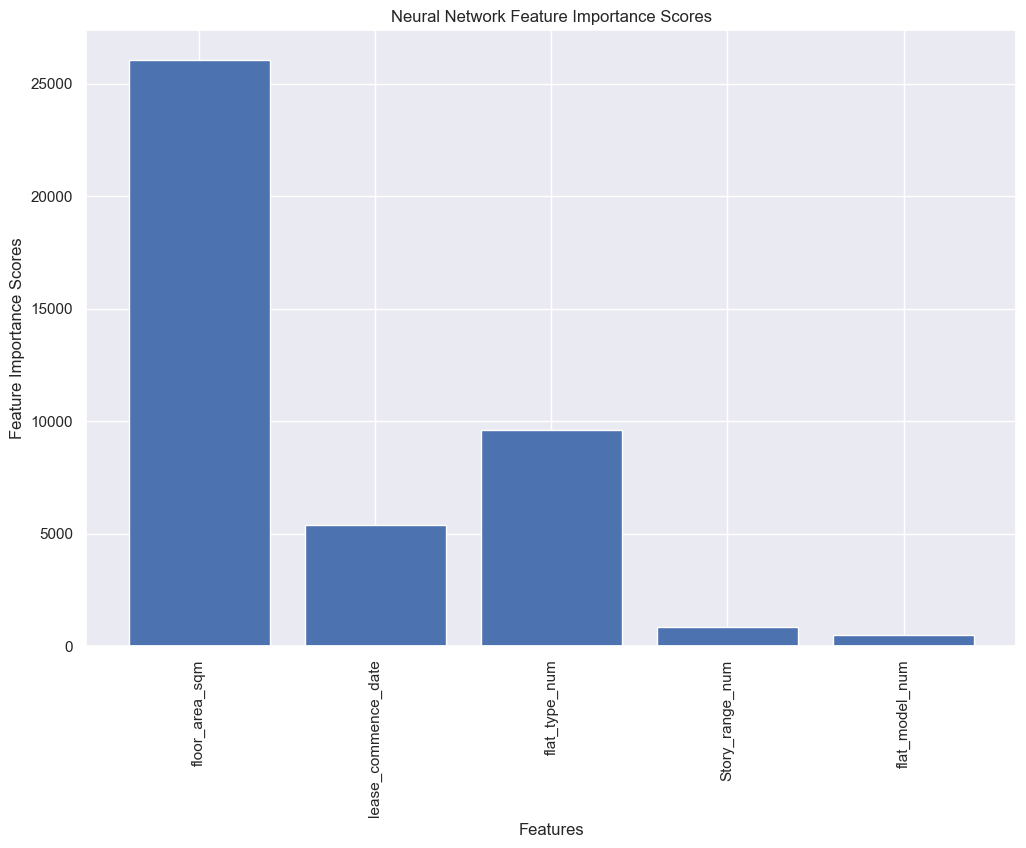

In [10]:
# Create a bar plot of the feature importance scores
plt.figure(figsize=(12,8))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance Scores')
plt.title('Neural Network Feature Importance Scores')
plt.show()

## Final Analysis <br>
Comparing the feature importance of Neural Network, `floor_area_sqm` and `flat_type_num` are the top 2 predictors in predicting resale_price and it actually conincides with our findings from the previous models. This further support the claim and our analysis that `floor_area_sqm` and `flat_type_num` are the best for numerical and categorical predictor respectively. <br>

Comparing Neural Network Model with Random Forest which was the best model in the previous notebook shows that the value of R^2 is actually lower and having a higher MSE when using Neural Network Model. This imply that Random Forest would be the better model when trying to predict resale_price of HDB. <br>

To conclude, `Random Forest` is the best model to be used to predict `resale_price` of HDB given the highest R^2 value and lowest MSE that is obtained from the model. The top predictors in predicting `resale_price` are `floor_area_sqm` and `flat_type_num`, with `flat_type_num` being the best predictor with it consistenly being the top in the features importance for multiple of the machine learning models.